In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error

import sys

sys.path.append("..")
sys.path.append("../src")
from src.DataHandling.processing import supervised_transform
import src.DataHandling.visualization as vis

# models
from src.Models.baseline import Baseline
from src.Models.ma import MovingAverage
from src.Models.lr import Regression

In [2]:
TURBINE_ID_BRITISH = 2  ### set turbine id here, nb: you have to run the notebook 'data_inspection.ipynb' first
TURBINE_ID_BRAZILIAN = 1  ### set turbine id here, nb: you have to run the notebook 'data_inspection.ipynb' first
HORIZONS = ["10min", "Hourly", "Daily"]
BENCHMARKS = pd.read_csv("../results_wind.csv")
BENCHMARKS

,name,RMSE,MAE,horizon,test_start,test_end
0,Kelmarsh_2,145.602811,91.553768,10min,2020-07-01,2021-06-30 23:50:00
1,Kelmarsh_2,263.749456,183.285915,hourly,2020-07-01,2021-06-30 23:50:00
2,Kelmarsh_2,623.023208,510.709616,daily,2020-07-01,2021-06-30 23:50:00
3,"Turbine 1, Beberibe",55.417200,36.244988,10min,2014-05-18 18:50:00,2014-07-31 23:50:00
4,"Turbine 1, Beberibe",119.249865,81.943719,hourly,2014-05-18 18:50:00,2014-07-31 23:50:00
5,"Turbine 1, Beberibe",196.741606,151.508157,daily,2014-05-18 18:50:00,2014-07-31 23:50:00


In [3]:
### create results dataframes for each turbine

results_brit = pd.DataFrame(
    data={
        "Horizon": HORIZONS,
        "RMSE": BENCHMARKS["RMSE"][0:3],
        "MAE": BENCHMARKS["MAE"][0:3],
    }
)
results_brit = pd.melt(
    results_brit,
    id_vars=["Horizon"],
    value_vars=["RMSE", "MAE"],
    value_name="Benchmark",
    var_name="Metric",
)

results_braz = pd.DataFrame(
    data={
        "Horizon": HORIZONS,
        "RMSE": BENCHMARKS["RMSE"][3:6],
        "MAE": BENCHMARKS["MAE"][3:6],
    }
)
results_braz = pd.melt(
    results_braz,
    id_vars=["Horizon"],
    value_vars=["RMSE", "MAE"],
    value_name="Benchmark",
    var_name="Metric",
)

In [4]:
# load cleaned data
turbine_brit = pd.read_csv(f"../data/cleaned/turbine_brit_{TURBINE_ID_BRITISH}.csv")

# use date column as index and convert to datetime
turbine_brit["Date"] = pd.to_datetime(turbine_brit["Date"])
turbine_brit.set_index("Date", inplace=True)
# turbine_two.head()

In [5]:
# transform data into a supervised learning problem
X, y = supervised_transform(
    df=turbine_brit, target_var="Power (kW)", time_steps_ahead=1, window_size=5
)

In [6]:
# create train and test set
test_start_brit = pd.to_datetime(BENCHMARKS["test_start"][0])
test_end_brit = pd.to_datetime(BENCHMARKS["test_end"][0])
test_start_braz = pd.to_datetime(BENCHMARKS["test_start"][3])
test_end_braz = pd.to_datetime(BENCHMARKS["test_end"][3])

X_train, X_test = X.loc[:test_start_brit], X.loc[test_start_brit:test_end_brit]
y_train, y_test = y.loc[:test_start_brit], y.loc[test_start_brit:test_end_brit]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((218818, 45), (218818,), (50451, 45), (50451,))

# 1. Baseline Model

The simplest model involves using the latest available value as prediction, which, in our scenario, is stored in the 'Power (kW) (time -1)' column.

In [7]:
res = []
predictions = []

for horizon in HORIZONS:
    model = Baseline(data=turbine_brit, horizon=horizon)
    model.fit(test_start=test_start_brit, test_end=test_end_brit)
    preds = model.predict()
    rmse = np.sqrt(mean_squared_error(y_true=model.y_test, y_pred=preds))
    mae = median_absolute_error(y_true=model.y_test, y_pred=preds)
    res.append([rmse, mae])
    predictions.append(preds)

results_brit["Baseline"] = np.ravel(np.array(res), order="F")

# 2. Moving Average

**Explanation of the Model:**

In [8]:
res = []
predictions = []

for horizon in HORIZONS:
    model = MovingAverage(
        data=turbine_brit, horizon=horizon, window_size=5, discount=0.9
    )
    model.fit(test_start=test_start_brit, test_end=test_end_brit)
    preds = model.predict()
    rmse = np.sqrt(mean_squared_error(y_true=model.y_test, y_pred=preds))
    mae = median_absolute_error(y_true=model.y_test, y_pred=preds)
    res.append([rmse, mae])
    predictions.append(preds)

results_brit["Moving Average"] = np.ravel(np.array(res), order="F")

# 3. Different kinds of Linear Regression

In [15]:
lrs = ["linear", "ridge", "lasso"]
for lr in lrs:
    res = []
    predictions = []
    for horizon in HORIZONS:
        model = Regression(
            data=turbine_brit, horizon=horizon, window_size=5, model=lr, alpha=1.2
        )
        model.fit(test_start=test_start_brit, test_end=test_end_brit)
        preds = model.predict()
        rmse = np.sqrt(mean_squared_error(y_true=model.y_test, y_pred=preds))
        mae = median_absolute_error(y_true=model.y_test, y_pred=preds)
        res.append([rmse, mae])
        predictions.append(preds)

    results_brit[lr] = np.ravel(np.array(res), order="F")

results_brit

/opt/miniconda3/envs/res_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e+07, tolerance: 8.852e+06
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/res_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e+08, tolerance: 8.852e+06
  model = cd_fast.enet_coordinate_descent(


,Horizon,Metric,Benchmark,Baseline,Moving Average,linear,ridge,lasso
0,10min,RMSE,145.602811,149.296785,174.491725,166.430324,154.275443,145.077662
1,Hourly,RMSE,263.749456,271.336872,267.049712,265.323893,262.901718,256.718897
2,Daily,RMSE,623.023208,755.568859,748.407836,630.175835,629.963393,619.106532
3,10min,MAE,91.553768,48.056987,62.864728,53.811435,53.482724,51.756004
4,Hourly,MAE,183.285915,101.282118,102.119498,120.063973,120.198919,119.279233
5,Daily,MAE,510.709616,377.401279,376.509077,441.819510,441.690612,440.123284


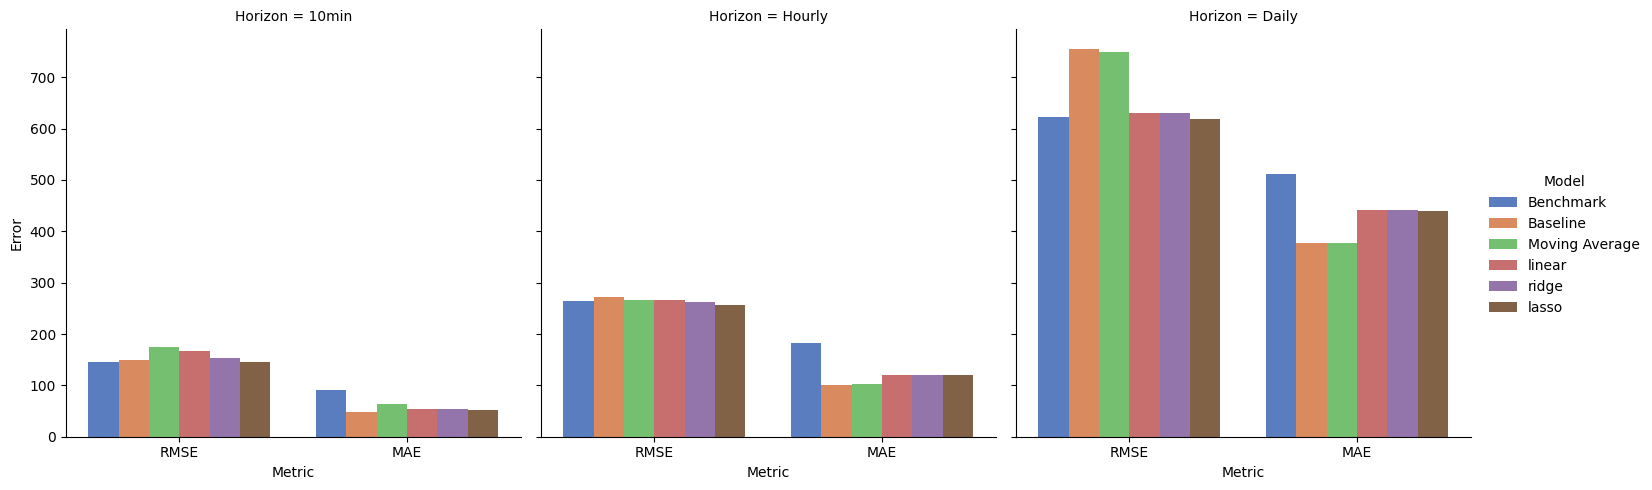

In [16]:
# plot results
vis.barplot_errors(
    df=results_brit,
    models=["Benchmark", "Baseline", "Moving Average", "linear", "ridge", "lasso"],
)